<a href="https://colab.research.google.com/github/SomTheSheep/Unsloth/blob/master/nb/LLAMAmultimodalPromptsANLSExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Read our **[Gemma 3N Guide](https://docs.unsloth.ai/basics/gemma-3n-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.11: Fast Mllama patching. Transformers: 4.54.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [3]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from transformers import TextStreamer
import numpy as np
import torch.nn.functional as F

Expected folder structure
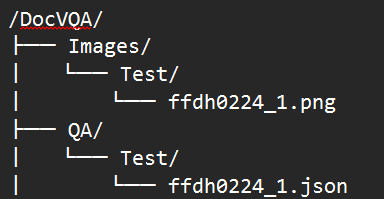

In [4]:
# 3. Set up Directories and Paths
root_dir = "/DocVQA"
image_dir = os.path.join(root_dir, "Images", "Val")
ocr_dir = os.path.join(root_dir, "OCR", "Val")
qa_dir = os.path.join(root_dir, "QA", "Val")

# Output JSON file for results
output_path = "/content/prompt_outputs_multimodal_val.json"


In [5]:
#4 Replace with your model and tokenizer initialization
# Assumes `model` and `tokenizer` are already loaded elsewhere (or load them here)
FastVisionModel.for_inference(model)
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

In [6]:
# 5. Helper Function to Extract Text
def extract_text_from_ocr(ocr_data):
    """Extract all text from OCR JSON data."""
    text_content = []
    if "recognitionResults" in ocr_data:
        for result in ocr_data["recognitionResults"]:
            if "lines" in result:
                for line in result["lines"]:
                    text_content.append(line["text"])
    return "\n".join(text_content)

In [7]:
# NEW CELL
import re
import string

def levenshtein_distance(s1, s2):
    """Calculates the Levenshtein distance between two strings."""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def normalize_text(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    s = s.lower()
    s = "".join(ch for ch in s if ch not in set(string.punctuation))
    s = re.sub(r"\b(a|an|the)\b", " ", s)
    s = " ".join(s.split())
    return s

def calculate_anls(prediction, ground_truths):
    """
    Calculates the Average Normalized Levenshtein Similarity (ANLS).
    The final score is the maximum ANLS score against all ground truth answers.
    """
    if not ground_truths:
        return 0.0

    prediction_norm = normalize_text(prediction)
    max_anls = 0.0

    for gt in ground_truths:
        gt_norm = normalize_text(gt)
        distance = levenshtein_distance(prediction_norm, gt_norm)
        max_len = max(len(prediction_norm), len(gt_norm))
        if max_len == 0:
            anls = 1.0 if distance == 0 else 0.0
        else:
            anls = 1.0 - (distance / max_len)
        if anls > max_anls:
            max_anls = anls

    return max_anls

def calculate_extractive_match(prediction, ground_truths):
    """
    Calculates if any ground truth is a substring of the prediction.
    Returns 1.0 for a match, 0.0 otherwise.
    """
    if not ground_truths:
        return 0.0

    prediction_norm = normalize_text(prediction)

    for gt in ground_truths:
        gt_norm = normalize_text(gt)
        if gt_norm in prediction_norm:
            return 1.0 # Found a match

    return 0.0 # No match found

def calculate_strict_match(prediction, ground_truths):
    """
    Calculates the strict match category based on normalized text.
    """
    prediction_norm = normalize_text(prediction)
    has_prediction = bool(prediction_norm)
    has_ground_truth = bool(ground_truths)

    if has_ground_truth:
        if not has_prediction:
            return "Missing"  # Expected an answer, but got none.

        ground_truths_norm = [normalize_text(gt) for gt in ground_truths]
        if prediction_norm in ground_truths_norm:
            return "Correct"  # Prediction matches a ground truth.
        else:
            return "Incorrect"  # Prediction does not match any ground truth.
    else: # No ground truth
        if has_prediction:
            return "Spurious"  # Predicted an answer, but none was expected.
        else:
            return "Correct" # Correctly predicted nothing when nothing was expected.

In [11]:
# 6. Main Processing Loop
# Collect all QA files
qa_files = sorted(os.listdir(qa_dir))

# Initialize the output data list, this will overwrite the file on each run.
all_data = []

# Initialize strict match counters
strict_match_counts = {"Correct": 0, "Incorrect": 0, "Missing": 0, "Spurious": 0}

# Iterate through each QA file to process the corresponding documents
for qa_filename in qa_files:
    file_id = qa_filename.replace(".json", "")
    qa_file_path = os.path.join(qa_dir, qa_filename)
    ocr_file_path = os.path.join(ocr_dir, f"{file_id}.json")
    image_path = os.path.join(image_dir, f"{file_id}.png") # Assuming images are .png

    # Skip if any of the required files are missing
    if not os.path.exists(image_path):
        print(f"Image file not found for {file_id} at {image_path}, skipping.")
        continue
    if not os.path.exists(ocr_file_path):
        print(f"OCR file not found for {file_id} at {ocr_file_path}, skipping.")
        continue

    # Load the document image
    try:
        image = Image.open(image_path)
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        continue

    # Load and extract text from the OCR data
    with open(ocr_file_path, "r") as f:
        ocr_data = json.load(f)
    document_text = extract_text_from_ocr(ocr_data)

    # Load the questions for the current document
    with open(qa_file_path, "r") as f:
        qa_items = json.load(f)

    # Ask each question about the document
    for qa in qa_items:
        question = qa["question"]
        ground_truth_answers = qa.get("answers", []) # Safely get ground truth

        # Prepare the multimodal prompt
        enhanced_question = f"""Based on the document image and the following text, please answer the question.

Document text:
{document_text}

Question: {question}

Answer:"""

        # Use the chat template for the instruct model
        messages = [
            {"role": "user", "content": [
                {"type": "image"},
                {"type": "text", "text": enhanced_question}
            ]}
        ]
        input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

        # Tokenize the inputs (image + text)
        inputs = tokenizer(
            image,
            input_text,
            add_special_tokens=False,
            return_tensors="pt"
        ).to("cuda")

        # Generate the response from the model
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=128,
                use_cache=False,
                temperature=1.5,
                min_p=0.1,
                output_scores=True,
                return_dict_in_generate=True,
            )

        # Extract generated tokens and scores
        generated_ids = outputs.sequences[:, inputs.input_ids.shape[1]:]
        scores = outputs.scores

        # Calculate confidence score
        token_confidences = []
        for i, token_id in enumerate(generated_ids[0]):
            # Get the logits for the current token
            logits = scores[i][0]
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # Get the probability of the generated token
            confidence = probs[token_id].item()
            token_confidences.append(confidence)

        # Average confidence for the entire answer
        avg_confidence = np.mean(token_confidences) if token_confidences else 0

         # Decode the response and clean it up
        decoded_output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        output_text = decoded_output.strip()

       # Calculate ANLS score
        anls_score = calculate_anls(output_text, ground_truth_answers)
        # Calculate Extractive Match score
        extractive_match = calculate_extractive_match(output_text, ground_truth_answers)
        # Calculate Strict Match category
        strict_match = calculate_strict_match(output_text, ground_truth_answers)
        strict_match_counts[strict_match] += 1

        print(f"\n[Document: {file_id}]")
        print(f"Q: {question}")
        print(f"A: {output_text}")
        if ground_truth_answers:
            print(f"Ground Truth: {ground_truth_answers[0]}")
            print(f"ANLS Score: {anls_score:.4f}")
            print(f"Extractive Match: {extractive_match}")
            print(f"Strict Match: {strict_match}")

        # Store the result
        all_data.append({
            "Document": file_id,
            "question": question,
            "output": output_text,
            "confidence": avg_confidence,
            "ground_truth": ground_truth_answers,
            "anls_score": anls_score,
            "extractive_match": extractive_match,
            "strict_match": strict_match,
        })
# 7. Save All Results to a JSON File
with open(output_path, "w") as f:
    json.dump(all_data, f, indent=2)

print(f"\nProcessing complete. All results saved to {output_path}")


[Document: ffbg0227_2]
Q: what is the page no or page mentioned ?
A: The page number is mentioned as 'Page 2' on the top left of the document.
Ground Truth: 2
ANLS Score: 0.1034
Extractive Match: 1.0
Strict Match: Incorrect

[Document: ffhx0227_1]
Q: What is the name of the University?
A: The name of the University is Vanderbilt University.
Ground Truth: Vanderbilt university
ANLS Score: 0.4884
Extractive Match: 1.0
Strict Match: Incorrect

[Document: ffjw0228_11]
Q: What is the Expenses for Salaries for 1986?
A: The expenses for salaries in 1986 were $123,110.
Ground Truth: $123,110
ANLS Score: 0.1463
Extractive Match: 1.0
Strict Match: Incorrect

[Document: ffjw0228_11]
Q: What is the Expenses for Publications for 1987?
A: The Expenses for Publications for 1987 is $10,596.
Ground Truth: 10,596
ANLS Score: 0.1163
Extractive Match: 1.0
Strict Match: Incorrect

[Document: ffjw0228_11]
Q: What is the Expenses for Publications for 1986?
A: According to the document, the Expenses for Publ

In [ ]:
if all_data:
    # Calculate average ANLS
    average_anls = np.mean([item['anls_score'] for item in all_data])

    # Calculate average Extractive Match
    average_extractive_match = np.mean([item['extractive_match'] for item in all_data])

    # Calculate Possible and Actual from strict match counts
    possible_count = strict_match_counts["Correct"] + strict_match_counts["Incorrect"] + strict_match_counts["Missing"]
    actual_count = strict_match_counts["Correct"] + strict_match_counts["Incorrect"] + strict_match_counts["Spurious"]

    print(f"\n--- Overall Metrics ---")
    print(f"Total Questions Processed: {len(all_data)}")
    print(f"Average ANLS: {average_anls:.4f}")
    print(f"Average Extractive Match: {average_extractive_match:.4f}")

    print("\n--- Strict Match Breakdown ---")
    for category, count in strict_match_counts.items():
        print(f"{category}: {count}")

    print(f"\nPossible: {possible_count}")
    print(f"Actual: {actual_count}")
else:
    print("\nNo data was processed to calculate average scores.")


--- Overall Metrics ---
Total Questions Processed: 86
Average ANLS: 0.3806
Average Extractive Match: 0.5698

--- Strict Match Breakdown ---
Correct: 19
Incorrect: 67
Missing: 0
Spurious: 0

Possible: 86
Actual: 86


G W Sugar refers to Great Western Sugar Company, which was a sugar company based in Denver, Colorado. The company was known for producing sugar and other related products. The image shows a receipt from the Great Western Sugar Company, which indicates that the company was involved in the sugar trade and distribution.</s>


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_seq_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.068 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 51,521,536/7,000,000,000 (0.74% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.787200
2,3.326000
3,3.431700
4,2.313500
5,2.053400
6,2.038500
7,1.522700
8,1.004700
9,0.716800
10,0.744900


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

219.9988 seconds used for training.
3.67 minutes used for training.
Peak reserved memory = 6.484 GB.
Peak reserved memory for training = 0.416 GB.
Peak reserved memory % of max memory = 43.986 %.
Peak reserved memory for training % of max memory = 2.822 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } \bar { N } ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \right\} .<|im_end|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

\frac { N } { M } \in \mathbf { Z } , \frac { P } { Q } \in \mathbf { Z } , P \in \mathbf { Z }<|im_end|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
